In [3]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Load files
dictionary_df = pd.read_excel('Dictionary 10.xlsx')
test_data_df = pd.read_csv('TEST DATA.csv')

# Extract dictionary columns
dictionary_columns = dictionary_df.columns.tolist()

# Initialize counts for each dictionary category
for column in dictionary_columns:
    test_data_df[column] = 0

# Tokenization function
def tokenize(sentence):
    return word_tokenize(sentence.lower())

# Function to count matches
def count_matches(sentence, dictionary_df):
    counts = {column: 0 for column in dictionary_df.columns}
    words = tokenize(sentence)
    for word in words:
        for column in dictionary_df.columns:
            if word in dictionary_df[column].dropna().str.lower().tolist():
                counts[column] += 1
    return counts

# Apply counting function to each row
for index, row in test_data_df.iterrows():
    counts = count_matches(row['Text'], dictionary_df)
    for column in dictionary_columns:
        test_data_df.at[index, column] = counts[column]

# Save the updated dataframe
output_file_path = 'Exact_Match_Tokenization_Output.csv'
test_data_df.to_csv(output_file_path, index=False)

print("Tokenization Processing Completed!")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenization Processing Completed!


In [ ]:
import pandas as pd

# Load the previously generated output file
output_file_path = 'Exact_Match_Tokenization_Output.csv'  # Update this path if necessary
output_df = pd.read_csv(output_file_path)

# Define the columns to process
columns_to_process = ["Self-Direction", "Stimulation", "Hedonism", "Achievement", "Power", "Security",
                      "Tradition", "Conformity", "Benevolence", "Universalism"]

# Iterate over each row
for idx, row in output_df.iterrows():
    # Check if all values are 0
    if (row[columns_to_process] == 0).all():
        continue  # Skip updating this row if all values are 0
    
    # Find the maximum value for the row
    max_value = row[columns_to_process].max()
    
    # Update columns: set to 1 if equal to max value, else 0
    for column in columns_to_process:
        output_df.at[idx, column] = 1 if row[column] == max_value else 0

# Save the updated output dataframe to a new CSV file
updated_output_file_path = 'Token_Updated_Output.csv'  # Update this path if necessary
output_df.to_csv(updated_output_file_path, index=False)

output_df.head()


In [ ]:
import pandas as pd

# Load the test score and updated output files
test_score_path = 'TEST SCORE UPD.csv'  # Update this path if necessary
updated_output_path = 'Token_Updated_Output.csv'  # Update this path if necessary

test_score_df = pd.read_csv(test_score_path)
updated_output_df = pd.read_csv(updated_output_path)

# Print the column names to check for discrepancies
print("Test Score Columns:")
print(test_score_df.columns)

print("\nUpdated Output Columns:")
print(updated_output_df.columns)

# Define the columns to process (update these if necessary based on the above output)
columns_to_process = ["Security", "Conformity", "Tradition", "Benevolence", "Universalism", 
                      "Self-Direction", "Stimulation", "Hedonism", "Achievement", "Power"]

# Merge dataframes based on Text-ID and Sentence-ID
merged_df = test_score_df.merge(updated_output_df, on=['Text-ID', 'Sentence-ID'], suffixes=('_test', '_updated'))

# Function to find headers with value 1
def find_headers_with_one(row, suffix):
    return ','.join([col for col in columns_to_process if row[f"{col}{suffix}"] == 1])

# Add new columns for headers with value 1
merged_df['Headers_1_test'] = merged_df.apply(lambda row: find_headers_with_one(row, '_test'), axis=1)
merged_df['Headers_1_updated'] = merged_df.apply(lambda row: find_headers_with_one(row, '_updated'), axis=1)

# Reorder columns
final_columns = ['Text-ID', 'Sentence-ID'] + \
                [f"{col}_test" for col in columns_to_process] + \
                [f"{col}_updated" for col in columns_to_process] + \
                ['Headers_1_test', 'Headers_1_updated']

final_df = merged_df[final_columns]

# Save to a new Excel file
output_excel_path = 'Token Combined_Output.xlsx'  # Update this path if necessary
final_df.to_excel(output_excel_path, index=False)

final_df.head()


In [ ]:
import pandas as pd

# Load the combined output file
combined_output_path = 'Token Combined_Output.xlsx'
combined_df = pd.read_excel(combined_output_path)

# Function to calculate the match percentage
def calculate_match_percentage(test_headers, updated_headers):
    if pd.isna(test_headers) and pd.isna(updated_headers):
        return 1.0, 1.0
    
    test_words = set(str(test_headers).split(',')) if pd.notna(test_headers) else set()
    updated_words = set(str(updated_headers).split(',')) if pd.notna(updated_headers) else set()
    
    matches = test_words.intersection(updated_words)
    num_matches = len(matches)
    
    test_percentage = num_matches / len(test_words) if test_words else 0.0
    updated_percentage = num_matches / len(updated_words) if updated_words else 0.0
    
    return test_percentage, updated_percentage

# Apply the function to each row and create new columns
combined_df[['Test_Match_Percentage', 'Updated_Match_Percentage']] = combined_df.apply(
    lambda row: calculate_match_percentage(row['Headers_1_test'], row['Headers_1_updated']), axis=1, result_type='expand'
)

# Calculate the total score for each column
total_rows = len(combined_df)
test_total_score = combined_df['Test_Match_Percentage'].sum() / total_rows
updated_total_score = combined_df['Updated_Match_Percentage'].sum() / total_rows

# Add the total score to the dataframe
combined_df.loc['Total'] = combined_df.sum(numeric_only=True)
combined_df.at['Total', 'Test_Match_Percentage'] = test_total_score
combined_df.at['Total', 'Updated_Match_Percentage'] = updated_total_score

# Save the updated dataframe to a new Excel file
updated_combined_output_path = 'Token Updated_Combined_Output.xlsx'
combined_df.to_excel(updated_combined_output_path, index=False)

combined_df.head(), test_total_score, updated_total_score


In [ ]:
import pandas as pd

# Load the Excel file
file_path = 'Token Updated_Combined_Output.xlsx'
data = pd.read_excel(file_path)

# Define the conditions for each category
exact_match = data[(data['Test_Match_Percentage'] == 1)]
partial_match = data[(data['Test_Match_Percentage'] > 0) & (data['Test_Match_Percentage'] < 1)]
different_value = data[(data['Test_Match_Percentage'] == 0) & (data['Headers_1_updated'].notnull()) & (data['Headers_1_updated'] != '')]
blank_value = data[(data['Test_Match_Percentage'] == 0) & (data['Headers_1_updated'].isnull() | (data['Headers_1_updated'] == ''))]

# Count the number of rows in each category
categories = {
    'Exact Match': exact_match.shape[0],
    'Partial Match': partial_match.shape[0],
    'Different Value': different_value.shape[0],
    'Blank Value': blank_value.shape[0]
}

# Output the field names and their respective counts
for category, count in categories.items():
    print(f"{category}: {count}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'Token Updated_Combined_Output.xlsx'
data = pd.read_excel(file_path)

# Define the conditions for each category
exact_match = data[(data['Test_Match_Percentage'] == 1)]
partial_match = data[(data['Test_Match_Percentage'] > 0) & (data['Test_Match_Percentage'] < 1)]
different_value = data[(data['Test_Match_Percentage'] == 0) & (data['Headers_1_updated'].notnull()) & (data['Headers_1_updated'] != '')]
blank_value = data[(data['Test_Match_Percentage'] == 0) & (data['Headers_1_updated'].isnull() | (data['Headers_1_updated'] == ''))]

# Count the number of rows in each category
categories = {
    'Exact Match': exact_match.shape[0],
    'Partial Match': partial_match.shape[0],
    'Different Value': different_value.shape[0],
    'Blank Value': blank_value.shape[0]
}

# Create the bar chart
fig, ax = plt.subplots()
ax.bar(categories.keys(), categories.values(), color=['green', 'yellow', 'black', 'grey'])

# Add labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Count')
ax.set_title('Test Match Categories Distribution')

# Display the bar chart
plt.show()


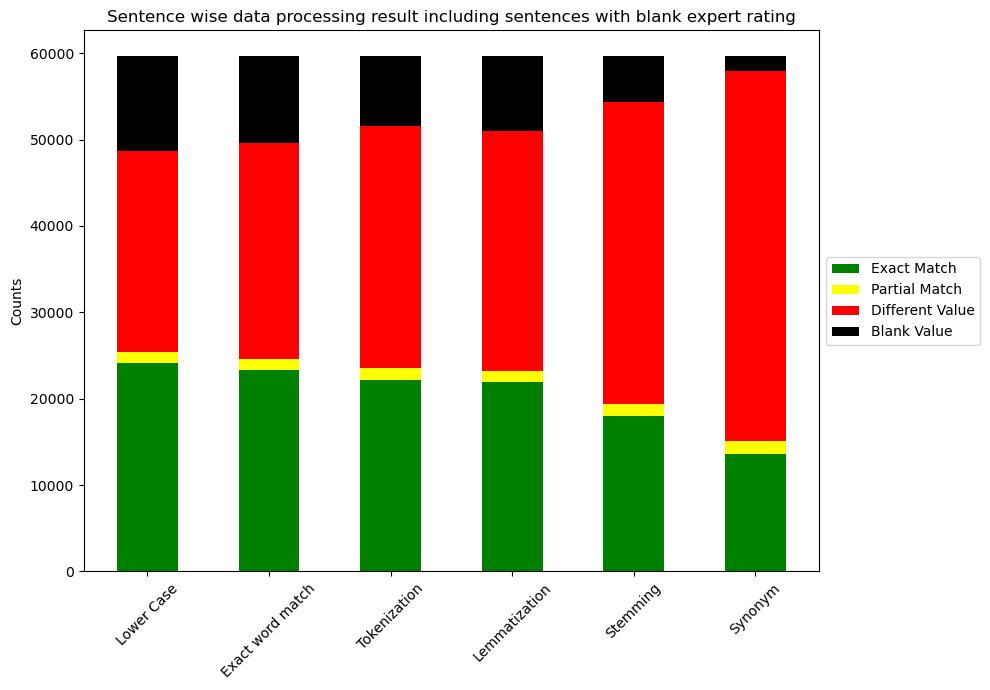

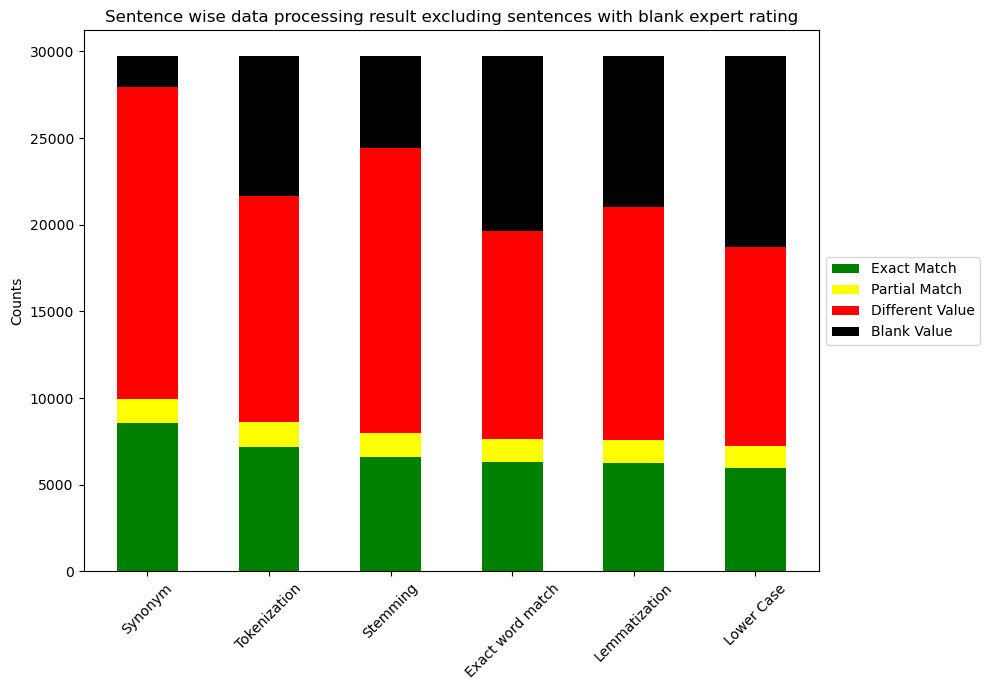

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data for "Sentence wise data processing result including sentences with blank expert rating"
methods_inc_blank = ['Lower Case', 'Exact word match', 'Tokenization', 'Lemmatization', 'Stemming', 'Synonym']
exact_match_inc_blank = [24157, 23309, 22160, 21880, 17979, 13637]
partial_match_inc_blank = [1292, 1338, 1429, 1305, 1409, 1409]
different_value_inc_blank = [23228, 24925, 27986, 27763, 34986, 42865]
blank_value_inc_blank = [10986, 10091, 8088, 8715, 5289, 1752]

# Data for "Sentence wise data processing result excluding sentences with blank expert rating"
methods_exc_blank = ['Synonym', 'Tokenization', 'Stemming', 'Exact word match', 'Lemmatization', 'Lower Case']
exact_match_exc_blank = [8539, 7203, 6579, 6292, 6252, 5948]
partial_match_exc_blank = [1408, 1428, 1408, 1338, 1304, 1291]
different_value_exc_blank = [18023, 13003, 16447, 12002, 13452, 11497]
blank_value_exc_blank = [1752, 8088, 5288, 10090, 8714, 10988]

# Plotting the first graph (including sentences with blank expert rating)
fig, ax = plt.subplots(figsize=(10, 7))
width = 0.5  # the width of the bars

# Stacked bars with specified colors
ax.bar(methods_inc_blank, exact_match_inc_blank, width, label='Exact Match', color='green')
ax.bar(methods_inc_blank, partial_match_inc_blank, width, bottom=exact_match_inc_blank, label='Partial Match', color='yellow')
ax.bar(methods_inc_blank, different_value_inc_blank, width, bottom=np.array(exact_match_inc_blank) + np.array(partial_match_inc_blank), label='Different Value', color='red')
ax.bar(methods_inc_blank, blank_value_inc_blank, width, bottom=np.array(exact_match_inc_blank) + np.array(partial_match_inc_blank) + np.array(different_value_inc_blank), label='Blank Value', color='black')

# Labels and title
ax.set_ylabel('Counts')
ax.set_title('Sentence wise data processing result including sentences with blank expert rating')

# Positioning legend on the right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the second graph (excluding sentences with blank expert rating)
fig, ax = plt.subplots(figsize=(10, 7))

# Stacked bars with specified colors
ax.bar(methods_exc_blank, exact_match_exc_blank, width, label='Exact Match', color='green')
ax.bar(methods_exc_blank, partial_match_exc_blank, width, bottom=exact_match_exc_blank, label='Partial Match', color='yellow')
ax.bar(methods_exc_blank, different_value_exc_blank, width, bottom=np.array(exact_match_exc_blank) + np.array(partial_match_exc_blank), label='Different Value', color='red')
ax.bar(methods_exc_blank, blank_value_exc_blank, width, bottom=np.array(exact_match_exc_blank) + np.array(partial_match_exc_blank) + np.array(different_value_exc_blank), label='Blank Value', color='black')

# Labels and title
ax.set_ylabel('Counts')
ax.set_title('Sentence wise data processing result excluding sentences with blank expert rating')

# Positioning legend on the right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
